## Importing Libraries

In [1]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models, layers, optimizers, regularizers
from keras.models import load_model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import ConfusionMatrixDisplay,  confusion_matrix
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from datetime import datetime
import os
import string

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/Audio/notebooks

## Function to Visualize Training History

In [3]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Loading Features 

In [4]:

df=pd.read_csv('../../features/features.csv')
df.shape

df.shape

(23225, 30)

## Train/Val/Test split

In [31]:

X = df.drop(['genre','file_name'],axis=1)
Y=df[['genre','file_name']]

X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.15, random_state=42)




## Labeling and Scaling Data

In [32]:

encoder = LabelEncoder()
y_test_num = encoder.fit_transform(y_test['genre'])
y_train_num = encoder.transform(y_train['genre'])
y_val_num = encoder.transform(y_val['genre'])


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(np.array(X_train, dtype = float))
X_val_scaled = scaler.transform(np.array(X_val, dtype = float))
X_test_scaled = scaler.transform(np.array(X_test, dtype = float))

## Saving scaler and encoder
    
import joblib
with open('../../models/transformers_6sec_14genres.joblib', 'wb') as f:
    joblib.dump([encoder,scaler], f)   
    


## MODELING

In [33]:


model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(layers.Dropout(0.2))
#model.add(BatchNormalization())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(BatchNormalization())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(BatchNormalization())

model.add(layers.Dense(128, activation='relu'))


model.add(layers.Dense(14, activation='softmax'))


In [34]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
callback = [#EarlyStopping(monitor='loss', patience=50, mode='auto'), # better results with proper DropOuts and without EarlyStopping
                  ModelCheckpoint(filepath='../../models/best_model_6sec_14genres_2.h5', monitor='accuracy', save_best_only=True)
                 ]

In [36]:
# history = model.fit(X_train_scaled, 
#                     y_train_num,
#                     epochs=500, 
#                     batch_size=128,  callbacks=callback, 
#                     validation_data=(X_val_scaled, y_val_num))

# visualize_training_results(history)

In [37]:
model = load_model('../../models/NN_model_6sec_14genres_new.h5')

### EVALUATION

In [38]:
score_test = model.evaluate(X_test_scaled, y_test_num, verbose=0)
print("Testing Accuracy: ", score_test[1])
print("Testing Cross Entropy: %.2f" % score_test[0])

score_test = model.evaluate(X_val_scaled, y_val_num, verbose=0)
print("Val Accuracy: ", score_test[1])
print("Val Cross Entropy: %.2f" % score_test[0])

Testing Accuracy:  0.9558665156364441
Testing Cross Entropy: 0.32
Val Accuracy:  0.9616074562072754
Val Cross Entropy: 0.29


In [29]:
y_hat=model.predict(X_test_scaled)
y_pred=np.argmax(y_hat, axis=1)

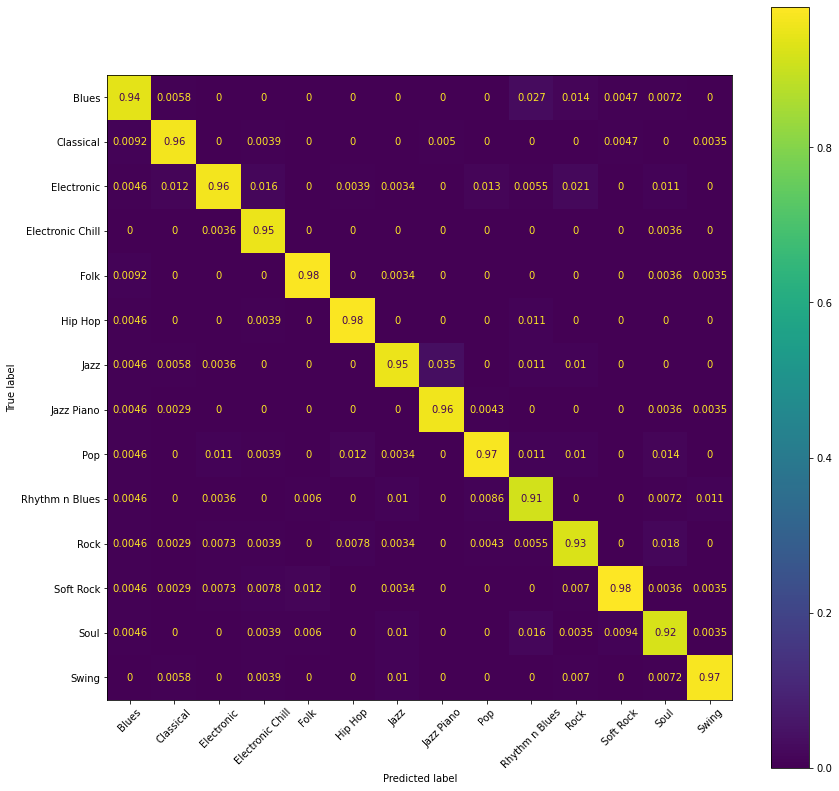

In [30]:
fig, ax = plt.subplots(figsize=(14,14))
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred, display_labels=encoder.classes_, ax=ax, normalize='pred')
plt.xticks(rotation=45);

## Saving a Model


In [ ]:
#model.save("../../models/last_model_6sec_14genres")